<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
    Project & Dataset Overview</div>
    <center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/White_Blood_Cells.svg/1024px-White_Blood_Cells.svg.png?20240925211923" width="400" style="margin-top: 20px;">
</center>

This study utilized fresh or cryopreserved human bone marrow and peripheral blood samples from healthy donors and AML patients, collected under IRB-approved protocols with informed consent. Mononuclear cells were isolated by Ficoll gradient and sorted via flow cytometry (FACS) using defined immunophenotypes to isolate HSCs, LSCs, blasts, and various normal cell types (excluding mature granulocytes and megakaryocytes). RNA-seq was performed on 1,000–100,000 FACS-purified cells using the NuGen Ovation V2 protocol, with sequencing libraries prepared via Illumina TruSeq and analyzed using STAR, HTSeq, and DESeq2. Fast-ATAC was performed on 5,000 sorted cells using a digitonin-based lysis and Tn5 transposition, with libraries sequenced on a NextSeq platform. Cell line data were obtained from GEO (GSE65360).

<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
    Library Load </div>
    <center>


In [17]:
library(ggplot2)
library(reshape2)
library(pander)
library(Hmisc)
library(pastecs)
library(DESeq2)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(clusterProfiler)
library(org.Hs.eg.db)
library(ReactomePA)
library(pheatmap)

In [18]:
# Set working directory
setwd("/Users/freddymappin/Desktop/ATAC_analysis")
getwd()

[1] "/Users/freddymappin/Desktop/ATAC_analysis"

In [19]:
# Load ATAC-seq data
df = read.table("atac.data.gz", header=T)

# Load sample information and parse sample names
si = read.table("blood.samples", header=F, stringsAsFactors=F)
colnames(si) = "sample"

# Extract cell type and donor information from sample names
# Sample format: Celltype_DonorID + Letter (e.g., Bcell_13A, CD4_9A, Erythroblast_15A)
si$celltype = gsub("_[0-9]+[A-Z]$", "", si$sample)  # Extract cell type
si$donor = "5483"  # All samples are from donor 5483
si$replicate = gsub("^.*([A-Z])$", "\\1", si$sample)  # Extract replicate letter

rownames(si) = si$sample
si$donor = factor(si$donor)
si$celltype = factor(si$celltype)

pander(dim(df), "Data dimensions")
print("Sample information:")
print(si)

_590650_ and _14_[1] "Sample information:"
                           sample     celltype donor replicate
Bcell_13A               Bcell_13A        Bcell  5483         A
Bcell_13B               Bcell_13B        Bcell  5483         B
CD4_9A                     CD4_9A          CD4  5483         A
CD4_9B                     CD4_9B          CD4  5483         B
CD8_10A                   CD8_10A          CD8  5483         A
CD8_10B                   CD8_10B          CD8  5483         B
Erythroblast_15A Erythroblast_15A Erythroblast  5483         A
Erythroblast_15B Erythroblast_15B Erythroblast  5483         B
Erythroblast_15C Erythroblast_15C Erythroblast  5483         C
NK_11A                     NK_11A           NK  5483         A
Nkcell_11B             Nkcell_11B       Nkcell  5483         B


In [20]:
pander(head(df))



| Chr  | Start  |  End   | Bcell_13A | CD4_9A | CD4_9B | CD8_10B |
|:----:|:------:|:------:|:---------:|:------:|:------:|:-------:|
| chr1 | 10025  | 10525  |     0     |   0    |   2    |    0    |
| chr1 | 13252  | 13752  |     0     |   4    |   0    |    2    |
| chr1 | 16019  | 16519  |     1     |   0    |   2    |    0    |
| chr1 | 96376  | 96876  |     0     |   0    |   0    |    0    |
| chr1 | 115440 | 115940 |     0     |   2    |   0    |    0    |
| chr1 | 235393 | 235893 |     2     |   4    |   2    |    0    |

Table: Table continues below

 

| Erythroblast_15A | Erythroblast_15B | Erythroblast_15C | NK_11A |
|:----------------:|:----------------:|:----------------:|:------:|
|        0         |        0         |        0         |   3    |
|        0         |        0         |        0         |   2    |
|        2         |        0         |        0         |   2    |
|        0         |        0         |        0         |   0    |
|        4         |

In [21]:
print(summary(si))

    sample                  celltype  donor     replicate        
 Length:11          Bcell       :2   5483:11   Length:11         
 Class :character   CD4         :2             Class :character  
 Mode  :character   CD8         :2             Mode  :character  
                    Erythroblast:3                               
                    NK          :1                               
                    Nkcell      :1                               


In [22]:
pander(head(si))



|    &nbsp;     |  sample   | celltype | donor | replicate |
|:-------------:|:---------:|:--------:|:-----:|:---------:|
| **Bcell_13A** | Bcell_13A |  Bcell   | 5483  |     A     |
| **Bcell_13B** | Bcell_13B |  Bcell   | 5483  |     B     |
|  **CD4_9A**   |  CD4_9A   |   CD4    | 5483  |     A     |
|  **CD4_9B**   |  CD4_9B   |   CD4    | 5483  |     B     |
|  **CD8_10A**  |  CD8_10A  |   CD8    | 5483  |     A     |
|  **CD8_10B**  |  CD8_10B  |   CD8    | 5483  |     B     |



<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
    Removing missing data </div>
    <center>


In [24]:
df = df[apply(df[,4:ncol(df)], 1, max) > 50,]
pander(dim(df), "Data dimensions")

_57891_ and _14_

In [25]:
cm = df[,4:ncol(df)]
pander(quantile(rowSums(cm)))



| 0% | 25% | 50% | 75% | 100%  |
|:--:|:---:|:---:|:---:|:-----:|
| 71 | 260 | 444 | 944 | 16021 |



In [26]:
pander(quantile(rowMeans(cm)))



|  0%   |  25%  |  50%  |  75%  | 100% |
|:-----:|:-----:|:-----:|:-----:|:----:|
| 6.455 | 23.64 | 40.36 | 85.82 | 1456 |



In [27]:
pander(quantile(apply(cm, 1, max)))



| 0% | 25% | 50% | 75% | 100% |
|:--:|:---:|:---:|:---:|:----:|
| 51 | 71  | 111 | 209 | 2471 |



In [10]:
print(mean(df$NK_11A))

[1] 12.08279


In [11]:
print(sd(df$NK_11A))

[1] 50.38444


<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
    EDA</div>
    <center>

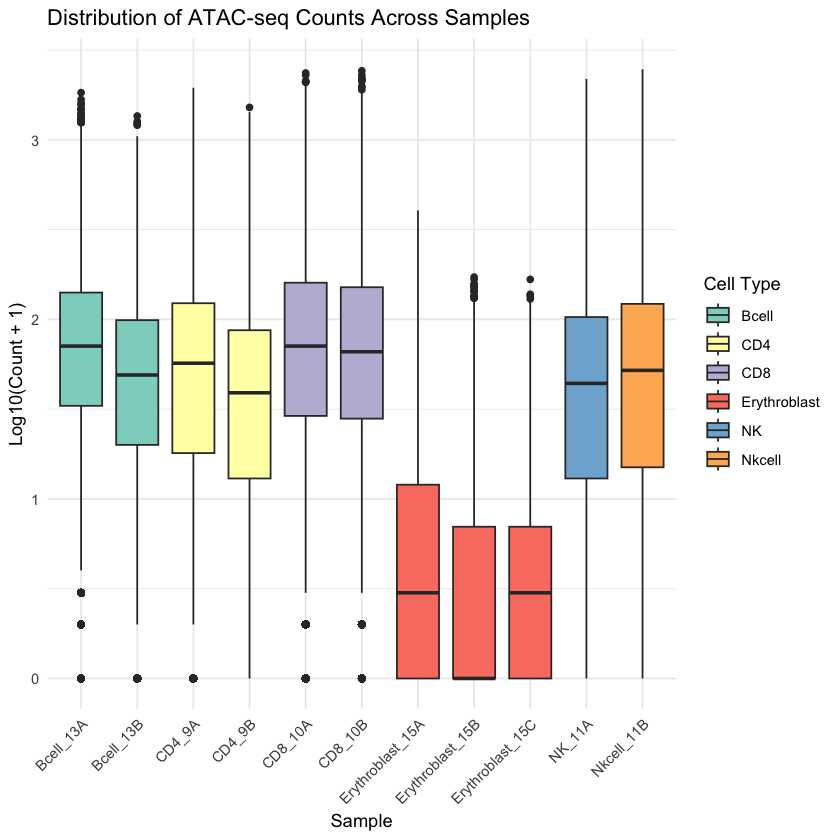

In [29]:
# Create boxplot of ATAC-seq counts across all samples
# Extract count matrix (excluding coordinate columns)
count_matrix = df[,4:ncol(df)]

# Melt the data for ggplot
library(reshape2)
melted_data = melt(as.matrix(count_matrix))
colnames(melted_data) = c("Region", "Sample", "Count")

# Add sample information
melted_data$Sample = as.character(melted_data$Sample)
melted_data = merge(melted_data, si, by.x="Sample", by.y="sample", all.x=TRUE)

# Create boxplot
p1 = ggplot(melted_data, aes(x=Sample, y=log10(Count + 1), fill=celltype)) +
  geom_boxplot() +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Distribution of ATAC-seq Counts Across Samples",
       x = "Sample", 
       y = "Log10(Count + 1)",
       fill = "Cell Type") +
  scale_fill_brewer(type = "qual", palette = "Set3")

print(p1)

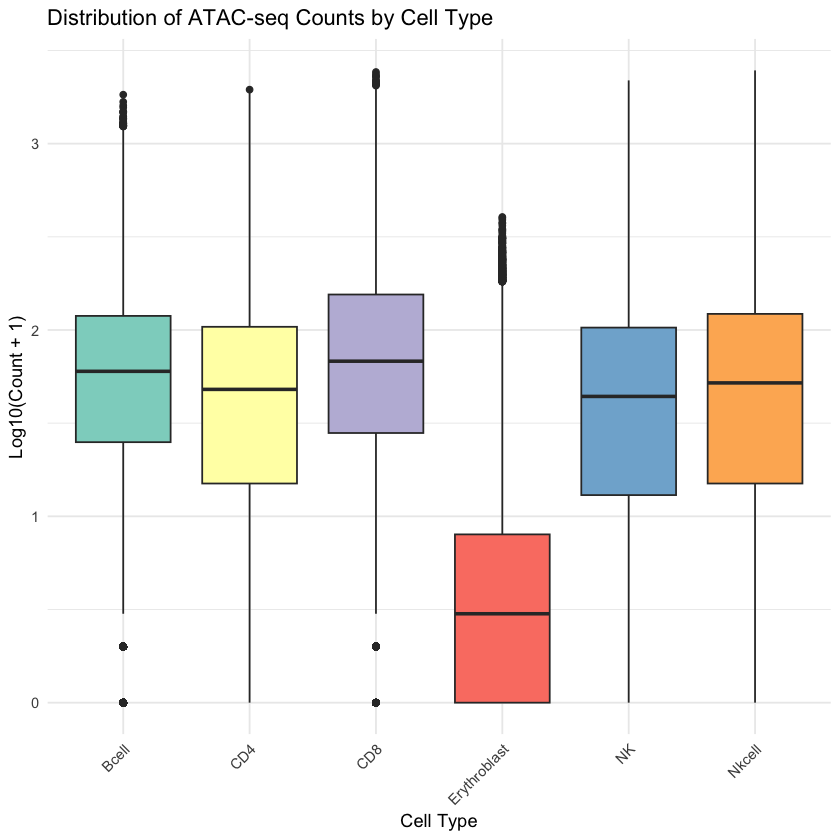

In [30]:
# Create a simpler boxplot grouped by cell type
p2 = ggplot(melted_data, aes(x=celltype, y=log10(Count + 1), fill=celltype)) +
  geom_boxplot() +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Distribution of ATAC-seq Counts by Cell Type",
       x = "Cell Type", 
       y = "Log10(Count + 1)",
       fill = "Cell Type") +
  scale_fill_brewer(type = "qual", palette = "Set3") +
  guides(fill = "none")

print(p2)

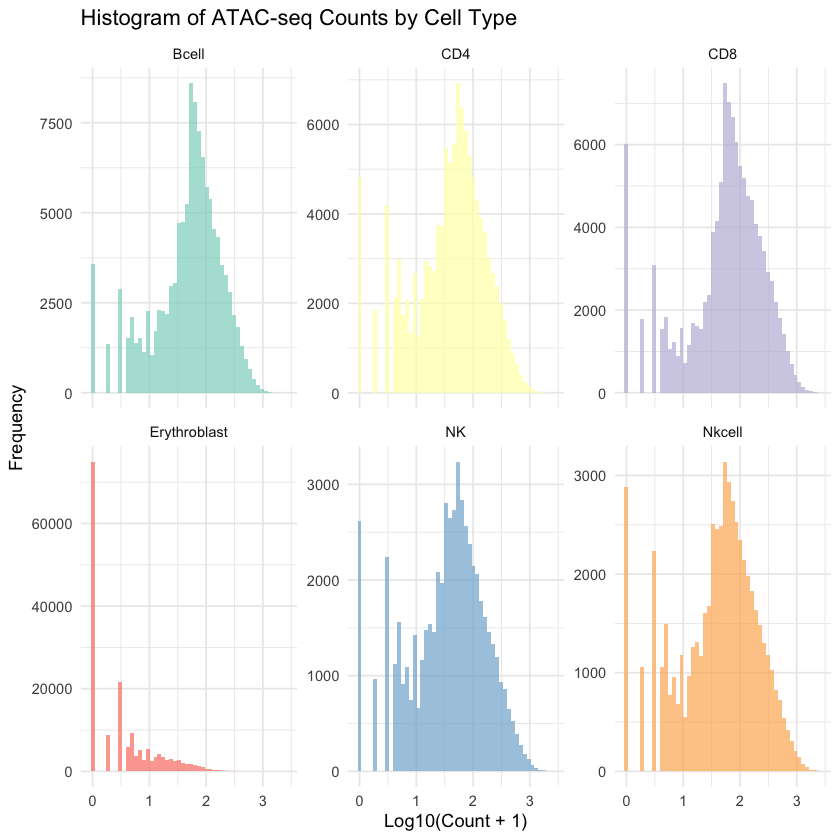

In [31]:
# Create histogram of ATAC-seq counts
# Use the melted_data from previous cells
p3 = ggplot(melted_data, aes(x=log10(Count + 1), fill=celltype)) +
  geom_histogram(bins = 50, alpha = 0.7) +
  facet_wrap(~celltype, scales = "free_y") +
  theme_minimal() +
  labs(title = "Histogram of ATAC-seq Counts by Cell Type",
       x = "Log10(Count + 1)", 
       y = "Frequency",
       fill = "Cell Type") +
  scale_fill_brewer(type = "qual", palette = "Set3") +
  guides(fill = "none")

print(p3)

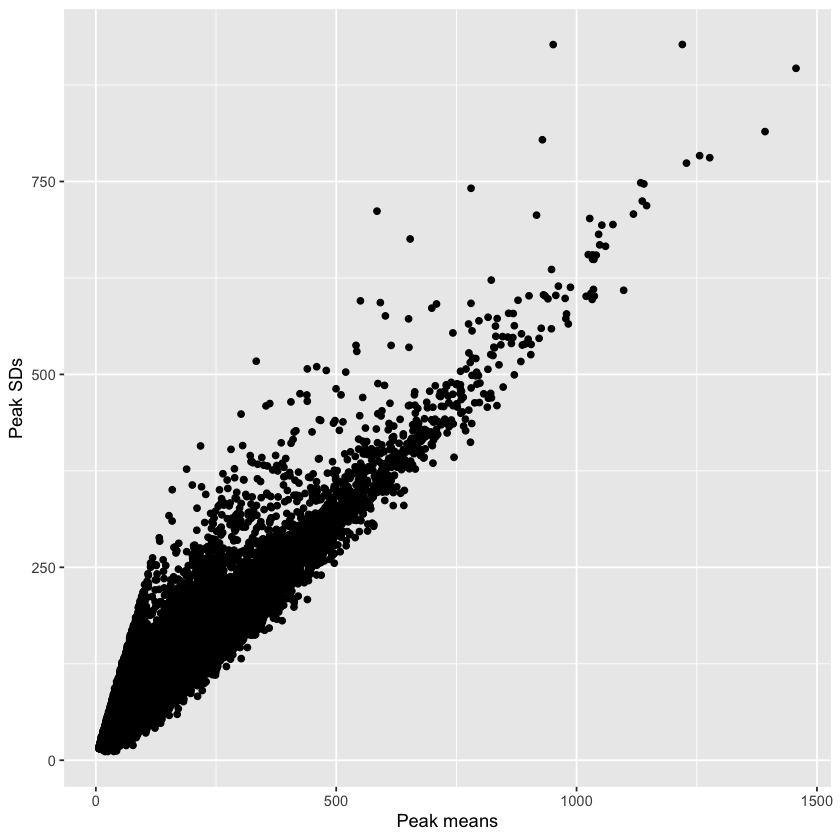

In [33]:
rowsummary = data.frame(rowmeans = apply(df[, 4:ncol(df)], 1, mean), rowsds = apply(df[, 4:ncol(df)], 1, sd))
ggplot(data=rowsummary, aes(x=rowmeans, y=rowsds)) + geom_point() + xlab("Peak means") + ylab("Peak SDs")

<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
    Data normalization </div>
    <center>

In [35]:
counts = df[,4:ncol(df)]
dds = DESeqDataSetFromMatrix(countData = counts[,order(colnames(counts))], colData = si, design = ~ celltype)
dds = DESeq(dds)
cm = data.frame(counts(dds, normalized=TRUE))
rownames(cm) = paste0(df$Chr, '_', df$Start, '_', df$End)

estimating size factors

estimating dispersions

estimating dispersions

gene-wise dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

final dispersion estimates

fitting model and testing

fitting model and testing



<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
    Data Visualization </div>
    <center>

In [36]:
lf = melt(cm, id.vars=c())
pander(head(lf))



| variable  | value |
|:---------:|:-----:|
| Bcell_13A | 120.3 |
| Bcell_13A | 28.59 |
| Bcell_13A | 36.76 |
| Bcell_13A | 36.31 |
| Bcell_13A | 24.51 |
| Bcell_13A | 41.3  |



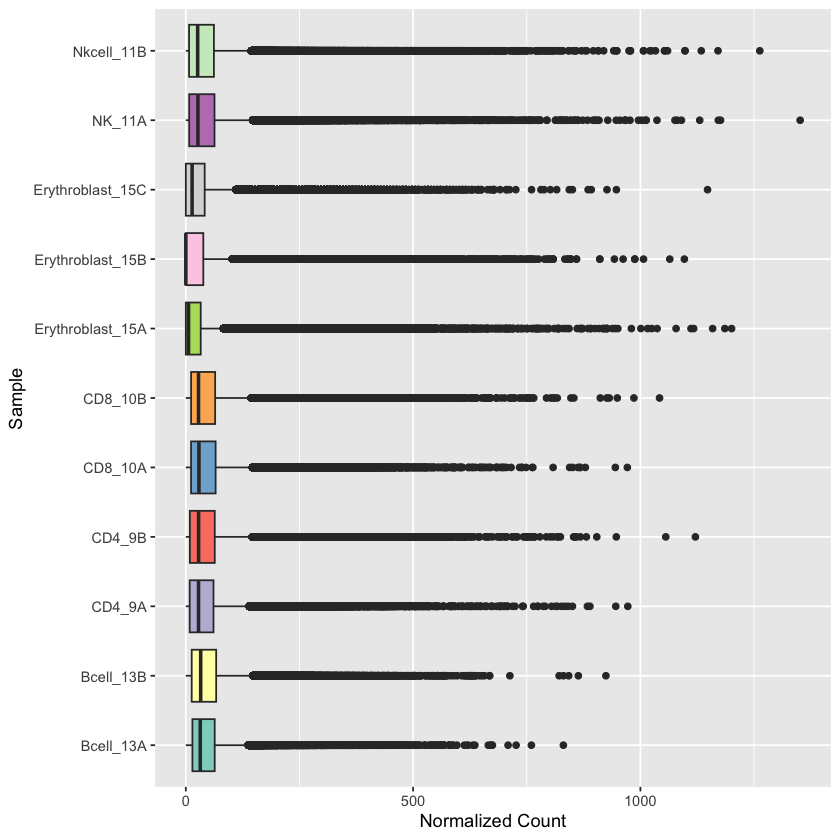

In [40]:
ggplot(data=lf, aes(x=variable, y=value, fill=variable)) + 
  geom_boxplot(aes(group=variable)) + 
  xlab("Sample") + 
  ylab("Normalized Count") + 
  coord_flip() + 
  scale_fill_brewer(type="qual", palette="Set3") + 
  guides(fill="none")

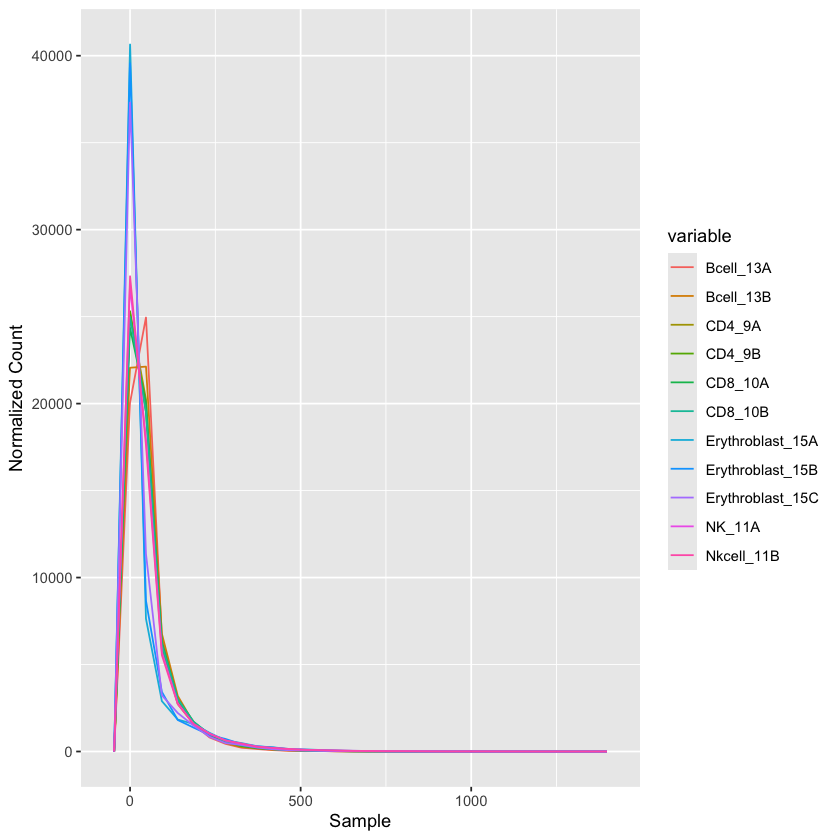

In [41]:
ggplot(data=lf, aes(x=value)) + geom_freqpoly(aes(group=variable, color=variable), bins=30) + xlab("Sample") + ylab("Normalized Count")


`geom_smooth()` using formula = 'y ~ x'


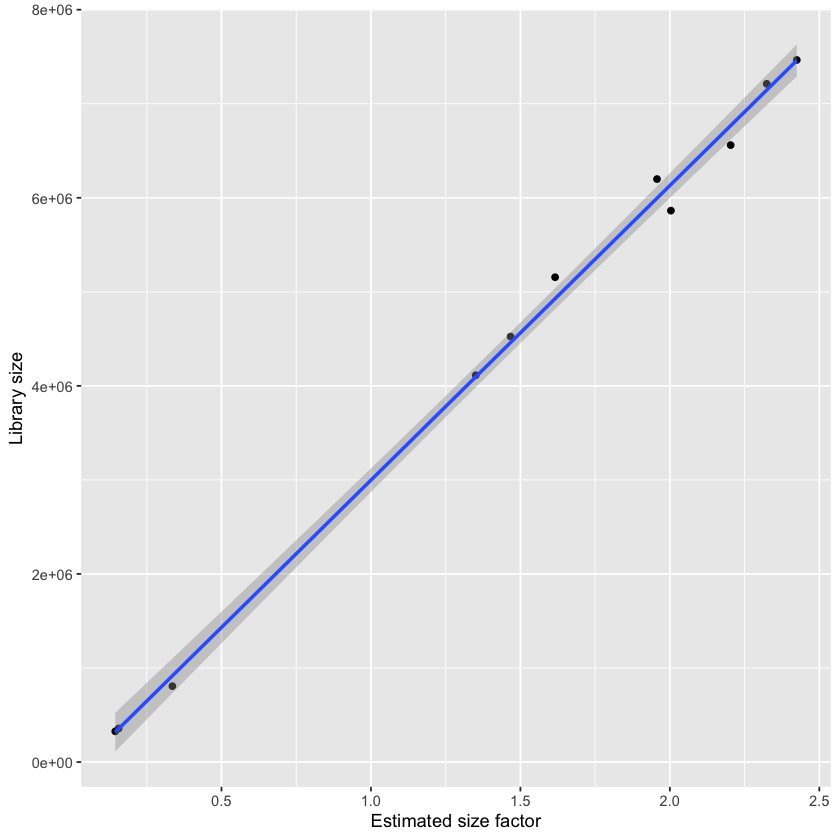

In [42]:
libsize = data.frame(x=sizeFactors(dds), y=colSums(assay(dds)))
ggplot(data=libsize, aes(x=x, y=y)) + geom_point() + geom_smooth(method="lm") + xlab("Estimated size factor") + ylab("Library size")

<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
     Principal component analysis (PCA) </div>
    <center>

In [43]:
pca = prcomp(t(cm))
print(summary(pca))

Importance of components:
                             PC1       PC2       PC3       PC4       PC5
Standard deviation     7401.6259 4460.2806 3302.6565 2.011e+03 1.698e+03
Proportion of Variance    0.5654    0.2053    0.1126 4.175e-02 2.977e-02
Cumulative Proportion     0.5654    0.7708    0.8833 9.251e-01 9.549e-01
                             PC6       PC7       PC8       PC9      PC10
Standard deviation     1.602e+03 837.51387 638.98215 610.83234 567.93309
Proportion of Variance 2.649e-02   0.00724   0.00421   0.00385   0.00333
Cumulative Proportion  9.814e-01   0.98861   0.99282   0.99667   1.00000
                            PC11
Standard deviation     2.026e-11
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00


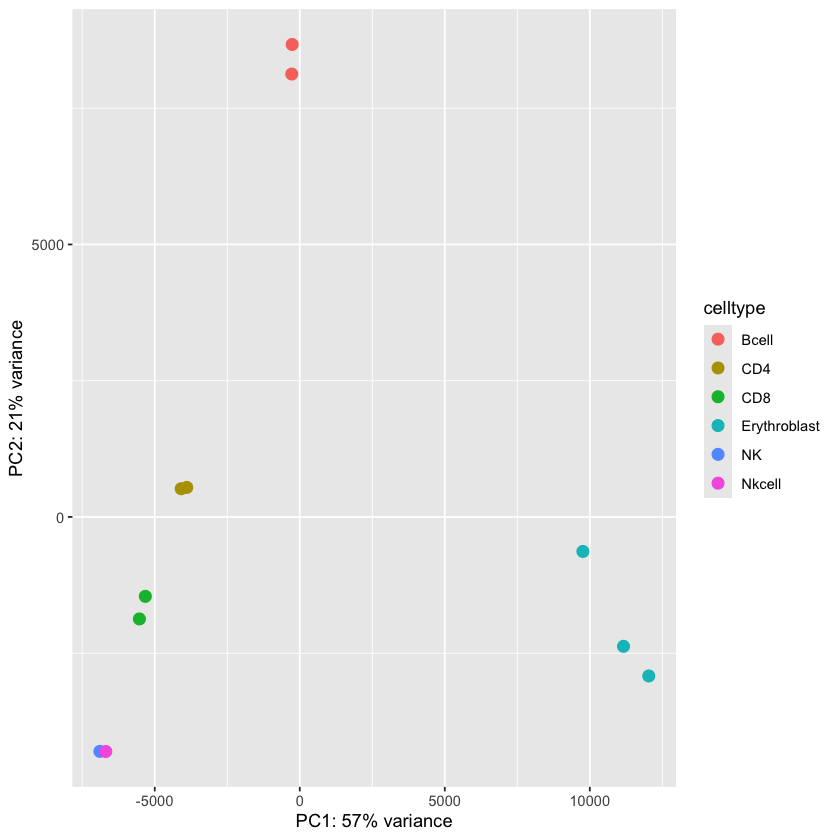

In [44]:
pcaData = as.data.frame(pca$x)
pcaData$sample=rownames(pcaData)
pcaData=merge(pcaData, si)
percentVar = round(100 * (pca$sdev^2 / sum( pca$sdev^2 ) ))
p=ggplot(data=pcaData, aes(x = PC1, y = PC2, color=celltype)) + geom_point(size=3)
p=p+xlab(paste0("PC1: ", percentVar[1], "% variance"))
p=p+ylab(paste0("PC2: ", percentVar[2], "% variance"))
print(p)

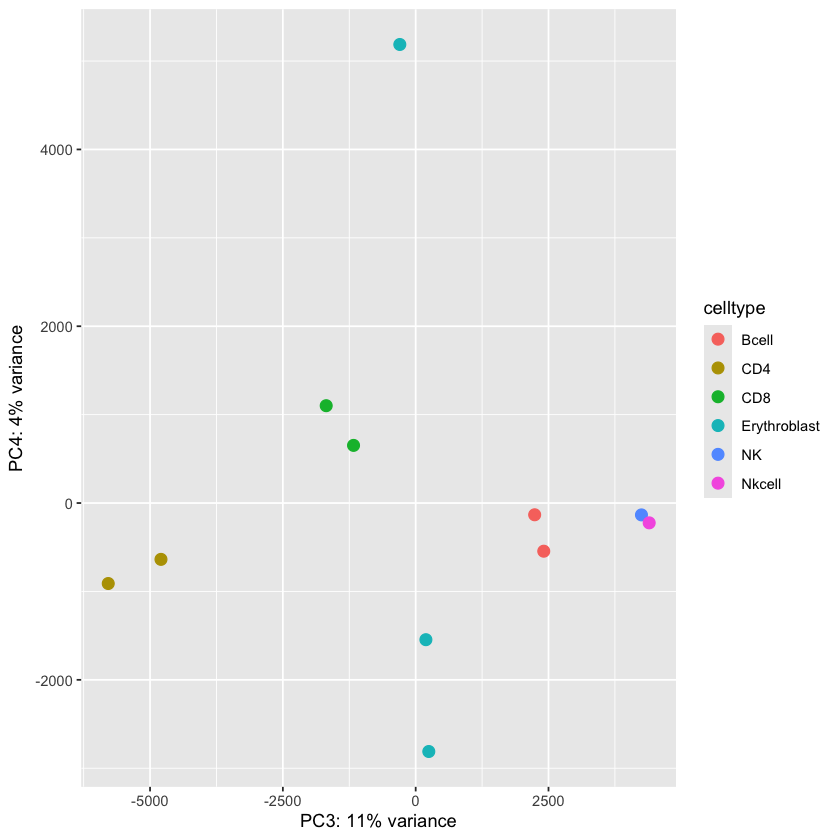

In [45]:
q=ggplot(data=pcaData, aes(x = PC3, y = PC4, color=celltype)) + geom_point(size=3)
q=q+xlab(paste0("PC3: ", percentVar[3], "% variance"))
q=q+ylab(paste0("PC4: ", percentVar[4], "% variance"))
print(q)

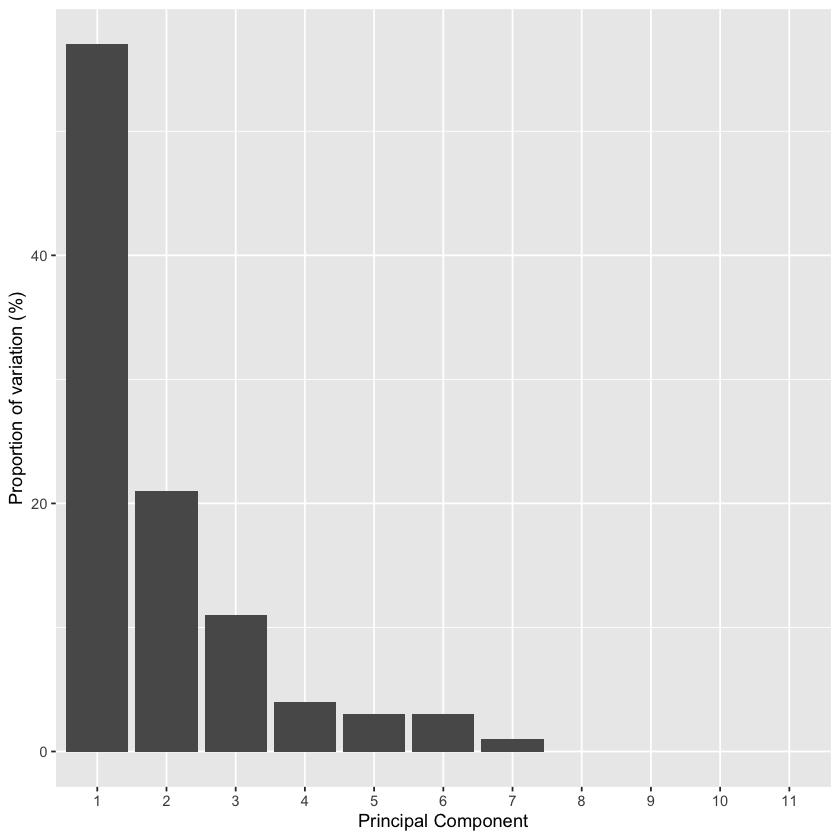

In [46]:
varexp = data.frame(x=1:length(percentVar), y=percentVar)
varexp$x = factor(varexp$x)
ggplot(data=varexp, aes(x=x, y=y)) + geom_bar(stat="identity") + xlab("Principal Component") + ylab("Proportion of variation (%)")

**Figure: Principal Component Analysis of ATAC-seq Data from Human Blood Cell Types**

**A-B.** PCA plots showing the first four principal components of normalized ATAC-seq accessibility data from 11 blood cell samples representing 6 distinct cell types from donor 5483. Each point represents an individual sample, colored by cell type. 

**A.** PC1 vs PC2 plot demonstrates that PC1 (capturing X% of variance) primarily separates Erythroblast samples from all other blood cell types, reflecting the distinct chromatin accessibility landscape of erythroid lineage cells. PC2 (capturing X% of variance) provides additional separation among the non-erythroid cell types.

**B.** PC3 vs PC4 plot reveals further heterogeneity within blood cell types, with PC3 and PC4 capturing X% and X% of variance respectively, highlighting subtle differences in chromatin accessibility patterns between related cell types such as CD4+ and CD8+ T cells, and different NK cell populations.

**C.** Variance explained plot shows the contribution of each principal component to the total variance in the dataset, with the first few components capturing the majority of biological variation in chromatin accessibility across blood cell types. This analysis demonstrates that blood cell types have distinctive chromatin accessibility signatures that can be captured through dimensionality reduction of ATAC-seq data.

<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
    Annotate genomic context</div>
    <center>

In [70]:
gr = makeGRangesFromDataFrame(df, keep.extra.columns=T)
peakAnno = annotatePeak(gr, tssRegion=c(-1000, 1000), TxDb=TxDb.Hsapiens.UCSC.hg19.knownGene, annoDb="org.Hs.eg.db")

>> preparing features information...		 2025-08-24 11:43:41 
>> identifying nearest features...		 2025-08-24 11:43:41 
>> calculating distance from peak to TSS...	 2025-08-24 11:43:41 
>> assigning genomic annotation...		 2025-08-24 11:43:41 
>> adding gene annotation...			 2025-08-24 11:43:42 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2025-08-24 11:43:42 
>> done...					 2025-08-24 11:43:42 


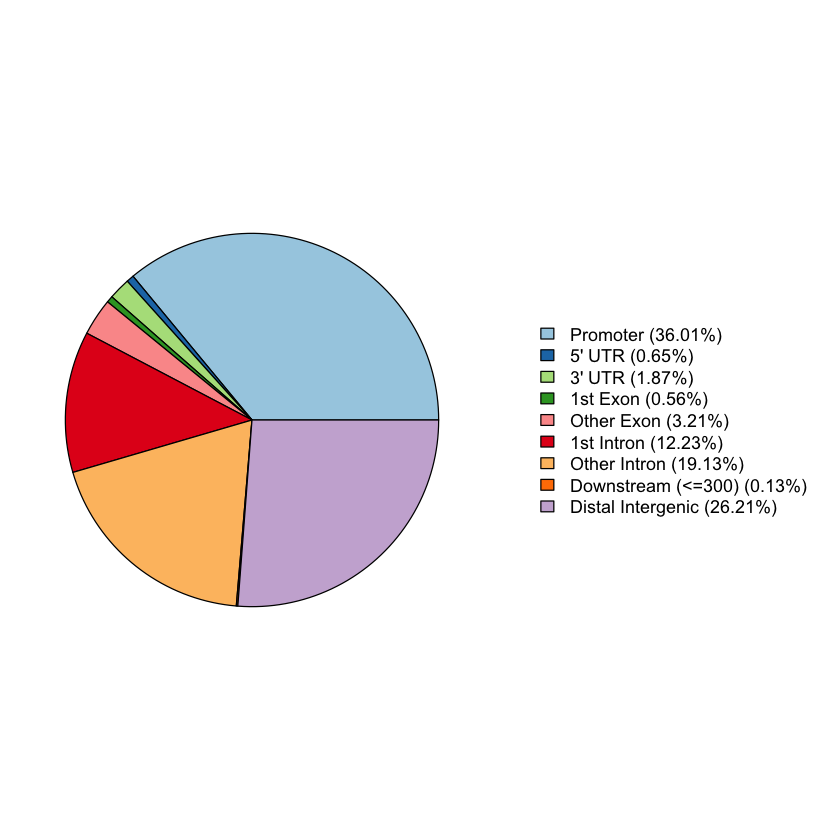

In [71]:
plotAnnoPie(peakAnno)

In [73]:
# Get the top 500 peaks with highest absolute loadings for PC1
pc1_loadings = abs(pca$rotation[,1])
top_pc1_peaks = names(sort(pc1_loadings, decreasing = TRUE)[1:500])

# Convert peak annotation to dataframe and match rownames
dfPA = as.data.frame(peakAnno)
rownames(dfPA) = paste0(dfPA$seqnames, '_', dfPA$start, '_', dfPA$end)

# Select peaks that correspond to top PC1 contributors
selpeaks = dfPA[top_pc1_peaks,]

# Perform pathway enrichment on genes near these peaks (within 5kb)
pathway1 = enrichPathway(selpeaks[abs(selpeaks$distance) < 5000,]$geneId)
pander(head(pathway1))



|      &nbsp;       |      ID       |       Description        | GeneRatio |
|:-----------------:|:-------------:|:------------------------:|:---------:|
| **R-HSA-6798695** | R-HSA-6798695 | Neutrophil degranulation |  16/123   |

Table: Table continues below

 

|      &nbsp;       |  BgRatio  | RichFactor | FoldEnrichment | zScore |
|:-----------------:|:---------:|:----------:|:--------------:|:------:|
| **R-HSA-6798695** | 479/11146 |   0.0334   |     3.027      |  4.79  |

Table: Table continues below

 

|      &nbsp;       |  pvalue   | p.adjust | qvalue  |
|:-----------------:|:---------:|:--------:|:-------:|
| **R-HSA-6798695** | 7.138e-05 | 0.03876  | 0.03876 |

Table: Table continues below

 

|      &nbsp;       |                                       geneID                                       |
|:-----------------:|:----------------------------------------------------------------------------------:|
| **R-HSA-6798695** | 210/8694/10383/847/5553/54472/23197/3043/3071

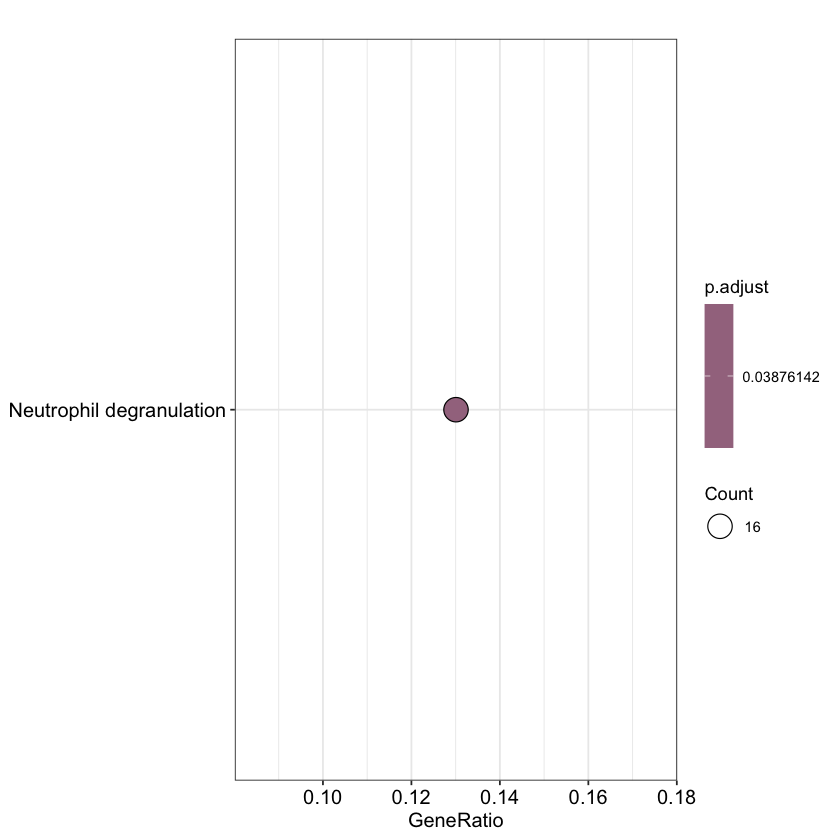

In [74]:
dotplot(pathway1)

<div style="padding:20px; 
            color:#150d0a;
            margin:0px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color: #90EE90;
            overflow:hidden;
            font-weight:500;
            border-radius: 0;">
     Differential Peak Calling </div>
    <center>

In [75]:
res = results(dds, lfcThreshold=1, contrast=c("celltype", "Bcell", "Erythroblast"))
print(mcols(res, use.names=T))

DataFrame with 6 rows and 2 columns
                       type            description
                <character>            <character>
baseMean       intermediate mean of normalized c..
log2FoldChange      results log2 fold change (ML..
lfcSE               results standard error: cell..
stat                results Wald statistic: cell..
pvalue              results Wald test p-value: c..
padj                results   BH adjusted p-values


In [76]:
print(summary(res))


out of 57891 with nonzero total read count
adjusted p-value < 0.1
LFC > 1.00 (up)    : 17499, 30%
LFC < -1.00 (down) : 2410, 4.2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


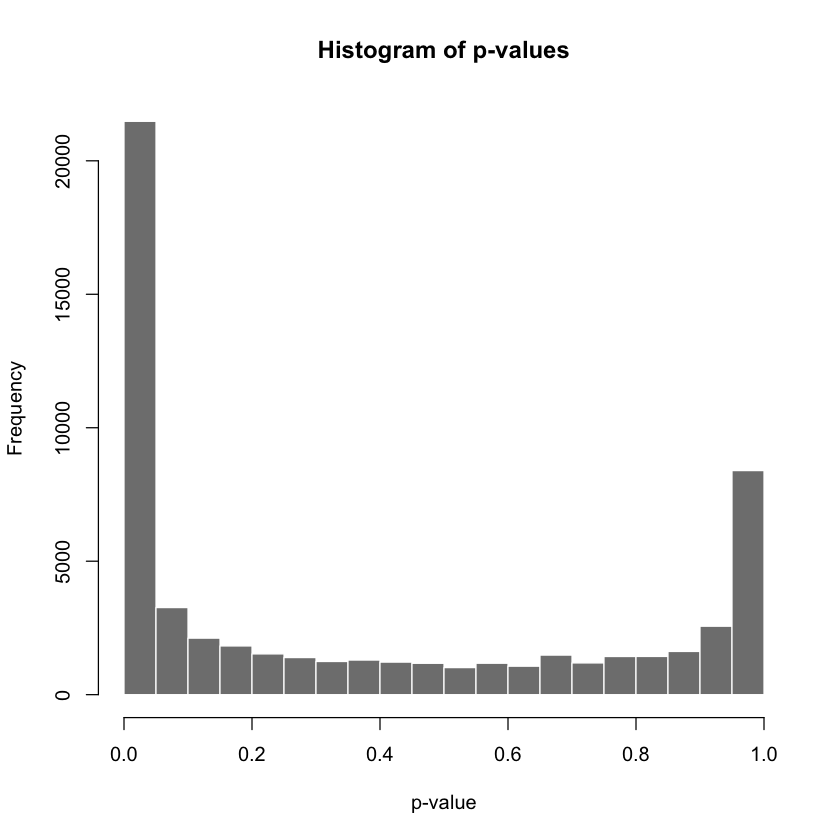

In [77]:
hist(res$pvalue, breaks=0:20/20, col="grey50", border="white", xlim=c(0,1), main="Histogram of p-values", xlab="p-value")


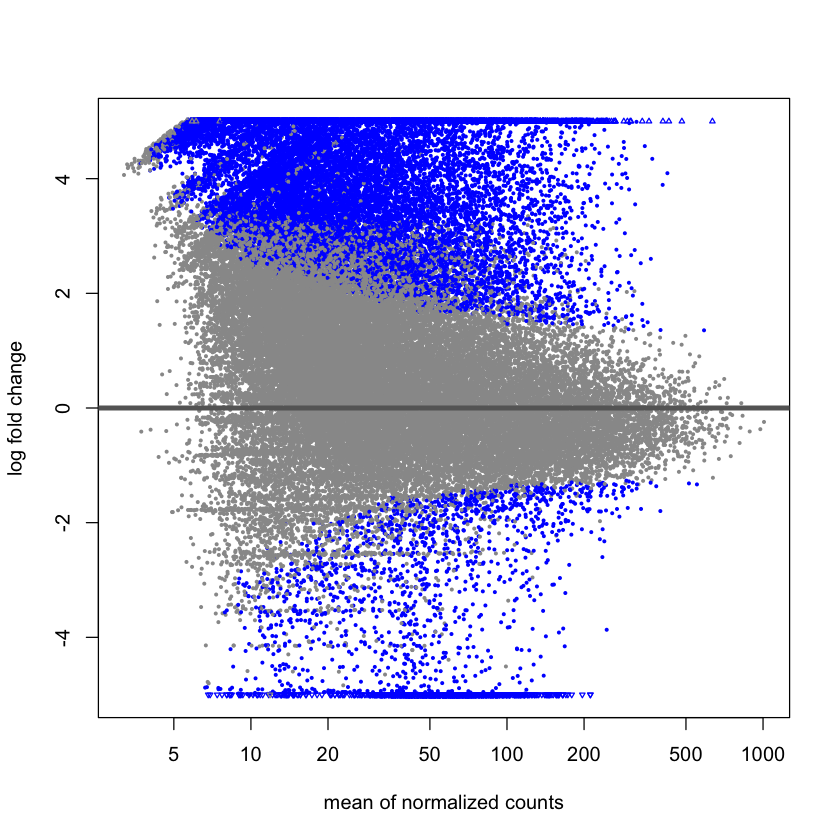

In [78]:
plotMA(res, ylim = c(-5, 5))

In [62]:
print(sum(res$padj < 0.01 & abs(res$log2FoldChange) > 1))

[1] 11043


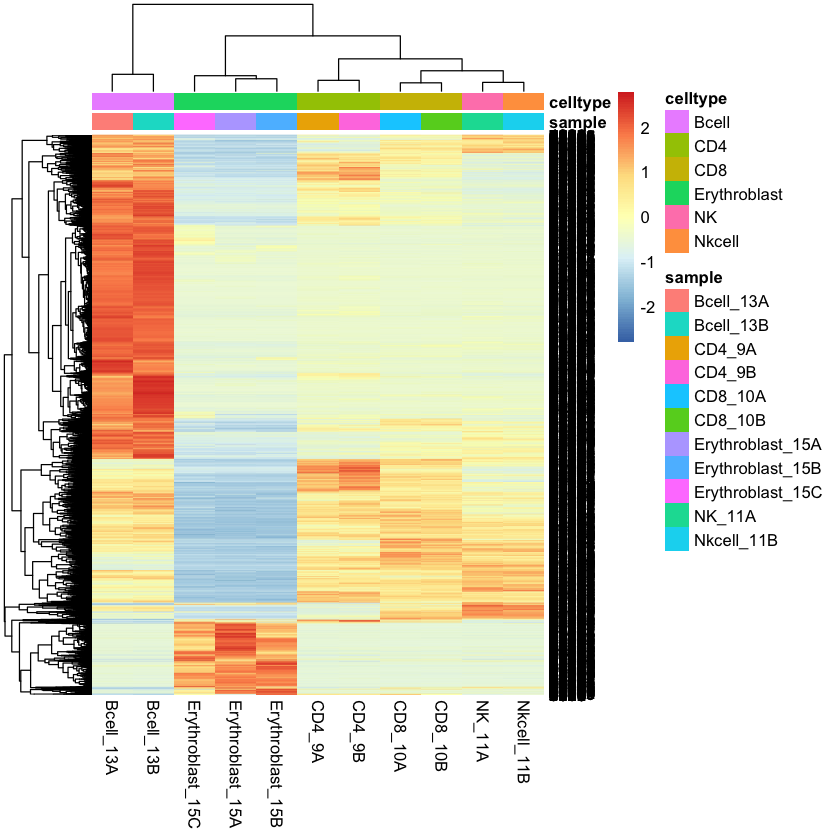

In [79]:
mat = cm[which(res$padj < 0.01 & abs(res$log2FoldChange) > 1),]
mat = mat - rowMeans(mat)
anno = as.data.frame(colData(dds)[, c("sample", "celltype")])
rownames(mat) = NULL
pheatmap(mat, annotation_col = anno, scale="row")

In [80]:
selpeaks = dfPA[rownames(cm[which(res$padj < 0.1 & res$log2FoldChange>0),]),]
pathwayUp = enrichPathway(selpeaks[abs(selpeaks$distance) < 5000,]$geneId)
pander(head(pathwayUp))



|      &nbsp;       |      ID       |
|:-----------------:|:-------------:|
| **R-HSA-9012999** | R-HSA-9012999 |
| **R-HSA-9013149** | R-HSA-9013149 |
| **R-HSA-9658195** | R-HSA-9658195 |
| **R-HSA-9824443** | R-HSA-9824443 |
| **R-HSA-4420097** | R-HSA-4420097 |
| **R-HSA-2029480** | R-HSA-2029480 |

Table: Table continues below

 

|      &nbsp;       |                  Description                   |
|:-----------------:|:----------------------------------------------:|
| **R-HSA-9012999** |                RHO GTPase cycle                |
| **R-HSA-9013149** |               RAC1 GTPase cycle                |
| **R-HSA-9658195** |              Leishmania infection              |
| **R-HSA-9824443** |          Parasitic Infection Pathways          |
| **R-HSA-4420097** |              VEGFA-VEGFR2 Pathway              |
| **R-HSA-2029480** | Fcgamma receptor (FCGR) dependent phagocytosis |

Table: Table continues below

 

|      &nbsp;       | GeneRatio |  BgRatio  | RichFactor |

In [81]:
selpeaks = dfPA[rownames(cm[which(res$padj < 0.1 & res$log2FoldChange<0),]),]
pathwayDown = enrichPathway(selpeaks[abs(selpeaks$distance) < 5000,]$geneId)
pander(head(pathwayDown))



|      &nbsp;      |      ID      |    Description    | GeneRatio |
|:----------------:|:------------:|:-----------------:|:---------:|
| **R-HSA-189451** | R-HSA-189451 | Heme biosynthesis |   7/522   |

Table: Table continues below

 

|      &nbsp;      | BgRatio  | RichFactor | FoldEnrichment | zScore |
|:----------------:|:--------:|:----------:|:--------------:|:------:|
| **R-HSA-189451** | 14/11146 |    0.5     |     10.68      |  8.03  |

Table: Table continues below

 

|      &nbsp;      |  pvalue   | p.adjust |  qvalue  |
|:----------------:|:---------:|:--------:|:--------:|
| **R-HSA-189451** | 1.223e-06 | 0.00153  | 0.001505 |

Table: Table continues below

 

|      &nbsp;      |               geneID               | Count |
|:----------------:|:----------------------------------:|:-----:|
| **R-HSA-189451** | 7389/28982/7390/3145/2235/9429/210 |   7   |

